# **Analisis de los datos**    


En esta etapa del desarrollo se evalúa la estructura del dataset, con el fin de definir y aplicar las trasnformaciones que sean requeridas para lograr una representación de características efectiva, que habilite el posterior modelamiento que de respuesta a la pregunta establecida como alcance del presente proyecto:    
\
*¿Cómo agrupar las reseñas escritas por los usuarios, para facilitar la comprensión de la percepción que se tiene sobre diferentes productos?*

In [1]:
!pip install pyspark
!apt install openjdk-11-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-11-jdk-headless is already the newest version (11.0.19+7~us1-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **Configuración y creación de la sesión de spark**

In [3]:
conf = SparkConf().set("spark.ui.port", "4050")

sc = SparkContext(conf = conf)
spark = SparkSession.builder.config("spark.driver.memory", "8g").getOrCreate()

spark

## **Cargando conjunto de Datos:**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
PATH_FEATURES_OUT = r"/content/drive/Shareddrives/MSc Ciencia Datos/Mineria/data/"
PATH_FEATURES_FILE = r"processed_reviews.parquet"
processed_reviews = spark.read.parquet(PATH_FEATURES_OUT + PATH_FEATURES_FILE).cache()

In [6]:
processed_reviews.show(10)

+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+-----+----------+-----------+-------------+-----------+----+-----------------+-----------+
|     review_id|         review_body|              tokens|        clean_tokens|      cleaned_tokens|      refined_tokens|num_tokens|         tf_features|            features|  uid|product_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_date|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+-----+----------+-----------+-------------+-----------+----+-----------------+-----------+
|R100GCI6ADKWZ0|my mother loves t...|[my, mother, love...|[my, mother, love...|[mother, loves, c...|[mother, love, co...|        17|(500,[1,10,73,123...|(500,[1,10,73,123...| 2645|6304400780|          4|  

In [7]:
print(f'tokens: {processed_reviews.count()}')

tokens: 66064


##WordCloud

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from wordcloud import WordCloud

In [9]:
spark = SparkSession.builder.appName("WordCloud").getOrCreate()

In [10]:
tokens = processed_reviews.select('refined_tokens')
tokens.show(10, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
print(f'tokens: {tokens.count()}')

tokens: 66064


In [12]:
tokens.printSchema()

root
 |-- refined_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [13]:
words= tokens.select(explode(tokens["refined_tokens"]).alias("word"))

In [14]:
word_counts = words.groupBy("word").count()

In [15]:
word_counts_p = word_counts.toPandas()

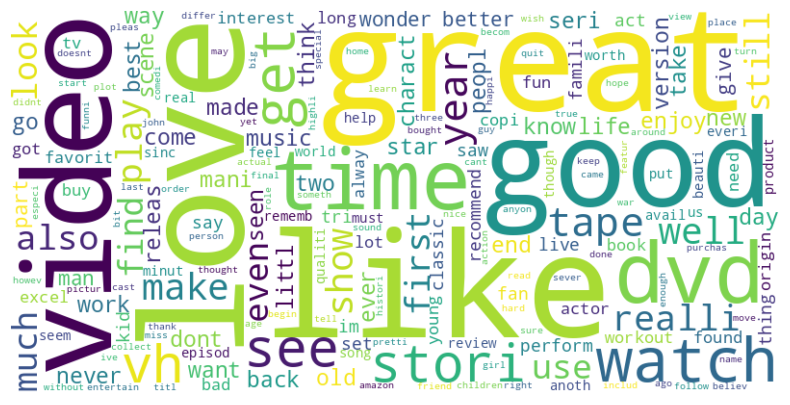

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts_p.set_index('word')['count'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Line chart

In [17]:
from pyspark.sql.functions import count, sum, avg, desc
import pyspark.sql.functions as sf

In [18]:
date_reviews= processed_reviews.groupBy('review_date').agg(count('review_id').alias('count')).sort(asc('review_date'))
date_reviews.show(10, False)

+-----------+-----+
|review_date|count|
+-----------+-----+
|2006-02-21 |4    |
|2006-02-22 |22   |
|2006-02-23 |34   |
|2006-02-24 |27   |
|2006-02-25 |26   |
|2006-02-26 |17   |
|2006-02-27 |27   |
|2006-02-28 |38   |
|2006-03-01 |36   |
|2006-03-02 |28   |
+-----------+-----+
only showing top 10 rows



In [19]:
date_reviews_p = date_reviews.toPandas()
date_reviews_p["review_date"] = pd.to_datetime(date_reviews_p["review_date"])


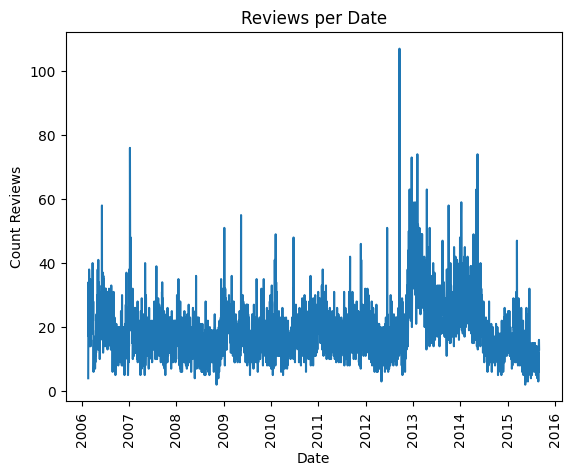

<Figure size 2500x1000 with 0 Axes>

In [20]:
plt.plot(date_reviews_p["review_date"], date_reviews_p["count"])
plt.xlabel("Date")
plt.ylabel("Count Reviews")
plt.xticks(rotation='vertical')
plt.title("Reviews per Date")
#
plt.figure(figsize=(25,10))
plt.show()

##Histograma numero de tokens

In [21]:
hist = processed_reviews.select('num_tokens')
hist_p = hist.toPandas()

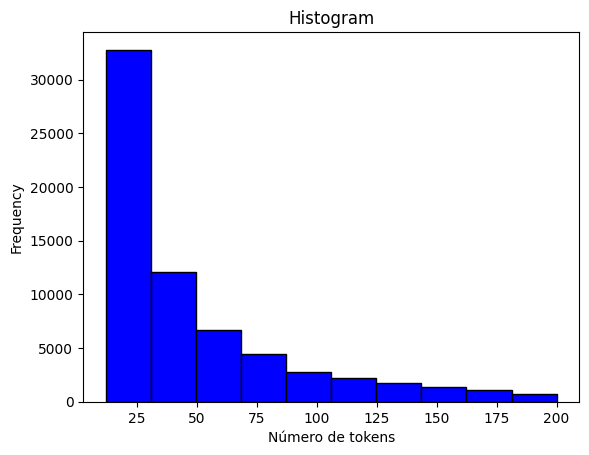

In [40]:
plt.hist(hist_p, bins=10, color="blue", edgecolor="black")
plt.xlabel("Número de tokens")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

##Stars Review

In [23]:
stars= processed_reviews.groupBy('star_rating').agg(count('review_id').alias('count')).sort(asc('star_rating'))
stars.show(10, False)

+-----------+-----+
|star_rating|count|
+-----------+-----+
|1          |4001 |
|2          |2779 |
|3          |6097 |
|4          |11829|
|5          |41358|
+-----------+-----+



In [24]:
t_votes= processed_reviews.groupBy('total_votes').agg(count('review_id').alias('count')).sort(desc('count'))
t_votes.show(10, False)

+-----------+-----+
|total_votes|count|
+-----------+-----+
|0          |25309|
|1          |15113|
|2          |8441 |
|3          |4971 |
|4          |3203 |
|5          |2116 |
|6          |1498 |
|7          |1096 |
|8          |816  |
|9          |550  |
+-----------+-----+
only showing top 10 rows



In [25]:
h_votes= processed_reviews.groupBy('helpful_votes').agg(count('review_id').alias('count')).sort(desc('count'))
h_votes.show(10, False)

+-------------+-----+
|helpful_votes|count|
+-------------+-----+
|0            |31832|
|1            |15112|
|2            |7129 |
|3            |3865 |
|4            |2404 |
|5            |1518 |
|6            |1018 |
|7            |678  |
|8            |488  |
|9            |335  |
+-------------+-----+
only showing top 10 rows



##Distinct products

In [26]:
products= processed_reviews.groupBy('product_id').agg(count('review_id').alias('count')).sort(desc('count'))
products.show(10, False)

+----------+-----+
|product_id|count|
+----------+-----+
|6302796857|59   |
|6301413229|59   |
|6303182135|52   |
|6302503493|45   |
|6302872162|41   |
|6301670108|39   |
|6304274742|38   |
|B00066J4PU|37   |
|6302208661|35   |
|6302670306|35   |
+----------+-----+
only showing top 10 rows



In [27]:
print(f'Productos: {products.count()}')

Productos: 35678


In [28]:
hist1 = products.select('count')
hist_p1 = hist1.toPandas()

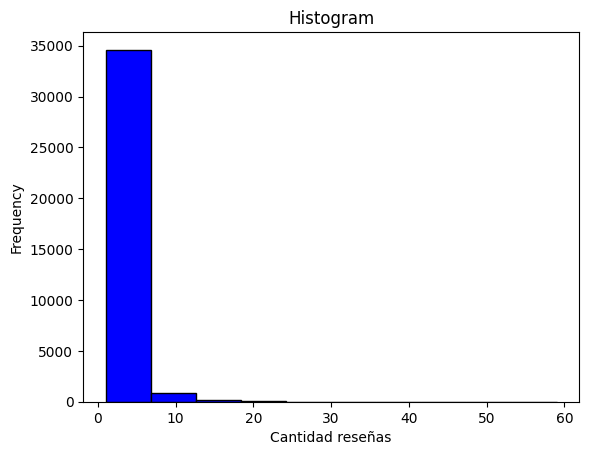

In [41]:
plt.hist(hist_p1, bins=10, color="blue", edgecolor="black")
plt.xlabel("Cantidad reseñas")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [30]:
products_more_10= products.filter(products['count'] >= 10)

In [31]:
print(f'Productos: {products_more_10.count()}')

Productos: 447


In [32]:
sum_column =products_more_10.agg(sum("count").alias("Total Reviews"))
sum_column.show()

+-------------+
|Total Reviews|
+-------------+
|         6571|
+-------------+



##Correlation

In [33]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import IntegerType
import seaborn as sns

In [34]:
numerical = processed_reviews.select('num_tokens','star_rating','helpful_votes')
numerical = numerical.withColumn('star_rating', numerical['star_rating'].cast(IntegerType()))
numerical = numerical.withColumn('helpful_votes', numerical['helpful_votes'].cast(IntegerType()))

In [35]:
numerical.printSchema()

root
 |-- num_tokens: integer (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)



In [36]:
vector_assembler = VectorAssembler(inputCols=numerical.columns, outputCol="features")
vectorized_df = vector_assembler.transform(numerical).select("features")

In [37]:
categorical_p= numerical.toPandas()

In [38]:
corr= categorical_p.corr()

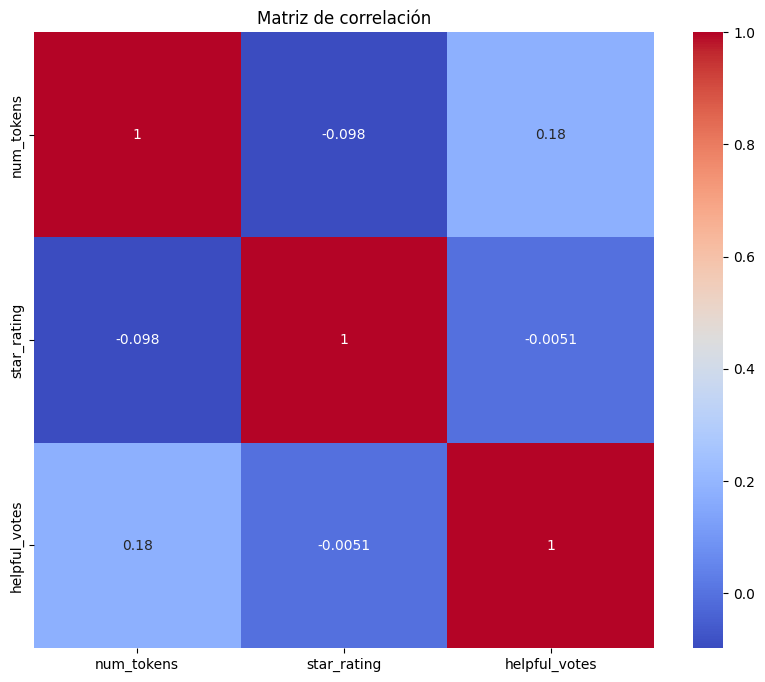

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()